# DML ATT Example

This notebook covers scenario:
| Is RCT        | Treatment | Outcome    | EDA | Estimands | Refutation |
|---------------|-----------|------------|-----|-----------|------------|
| Observational | Binary    | Continuous | Yes | ATT       | Yes        |

We will estimate Average Treatment Effect on Treated (ATT) of binary treatment on continuous outcome. It shows explonatary data analysis and refutation tests

## Generate data

Example that generates observational data with a nonlinear outcome model, nonlinear treatment assignment, and a heterogeneous (nonlinear) treatment effect tau(X). This setup ensures that ATT ≠ ATE in general. It also shows how to compute the “ground-truth” ATT from the generated data.

In [1]:
# Nonlinear ATT data generation with heterogeneous effects

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from causalkit.data import CausalDatasetGenerator, CausalData

# Reproducibility
np.random.seed(42)

# 1) Confounders and their distributions
#    These names define the column order in X for the custom functions.
confounder_specs = [
    {"name": "tenure_months",     "dist": "normal",   "mu": 24, "sd": 12},
    {"name": "avg_sessions_week", "dist": "normal",   "mu": 5,  "sd": 2},
    {"name": "spend_last_month",  "dist": "uniform",  "a": 0,   "b": 200},
    {"name": "premium_user",      "dist": "bernoulli","p": 0.25},
    {"name": "urban_resident",    "dist": "bernoulli","p": 0.60},
]

# Indices (for convenience inside g_y, g_t, tau)
TENURE, SESS, SPEND, PREMIUM, URBAN = range(5)

# 2) Nonlinear baseline for outcome f_y(X) = X @ beta_y + g_y(X)
#    Keep a modest linear part and add meaningful nonlinearities.
beta_y = np.array([
    0.03,   # tenure_months
    0.20,   # avg_sessions_week
    0.01,   # spend_last_month
    1.20,   # premium_user
    0.60,   # urban_resident
], dtype=float)

def g_y(X: np.ndarray) -> np.ndarray:
    # Nonlinearities and interactions in outcome baseline
    tenure_years = X[:, TENURE] / 12.0
    sessions = X[:, SESS]
    spend = X[:, SPEND]
    premium = X[:, PREMIUM]
    urban = X[:, URBAN]

    return (
        1.2 * np.sin(2.0 * np.pi * tenure_years)          # seasonal-ish tenure pattern
        + 0.02 * (sessions - 5.0) ** 2                    # convex effect of sessions
        + 0.0015 * (spend - 100.0) * (sessions - 5.0)     # spend × sessions interaction
        + 0.4 * premium * (sessions - 5.0)                # premium × sessions interaction
        + 0.3 * urban * np.tanh((spend - 100.0) / 50.0)   # nonlinear spend effect differs by urban
    )

# 3) Nonlinear treatment score f_t(X) = X @ beta_t + g_t(X)
beta_t = np.array([
    0.010,  # tenure_months
    0.12,   # avg_sessions_week
    0.001,  # spend_last_month
    0.80,   # premium_user
    0.25,   # urban_resident
], dtype=float)

def g_t(X: np.ndarray) -> np.ndarray:
    tenure_years = X[:, TENURE] / 12.0
    sessions = X[:, SESS]
    spend = X[:, SPEND]
    premium = X[:, PREMIUM]
    urban = X[:, URBAN]

    # Smoothly increasing selection with spend; interactions make selection non-separable
    soft_spend = 1.2 * np.tanh((spend - 80.0) / 40.0)
    return (
        0.6 * soft_spend
        + 0.15 * (sessions - 5.0) * (tenure_years - 2.0)
        + 0.25 * premium * (urban - 0.5)
    )

# 4) Heterogeneous, nonlinear treatment effect tau(X) on the natural scale (continuous outcome)
def tau_fn(X: np.ndarray) -> np.ndarray:
    tenure_years = X[:, TENURE] / 12.0
    sessions = X[:, SESS]
    spend = X[:, SPEND]
    premium = X[:, PREMIUM]
    urban = X[:, URBAN]

    # Base effect + stronger effect for higher sessions and premium users,
    # diminishes with tenure, mild modulation by spend and urban
    tau = (
        1.0
        + 0.8 * (1.0 / (1.0 + np.exp(-(sessions - 5.0))))    # sigmoid in sessions
        + 0.5 * premium
        - 0.6 * np.clip(tenure_years / 5.0, 0.0, 1.0)        # taper with long tenure
        + 0.2 * urban * (spend - 100.0) / 100.0
    )
    # Optional: keep it in a reasonable range
    return np.clip(tau, 0.2, 2.5)

# 5) Noise and prevalence
sigma_y = 1
target_t_rate = 0.35  # enforce ~35% treated via intercept calibration

# 6) Build generator
gen = CausalDatasetGenerator(
    outcome_type="continuous",
    sigma_y=sigma_y,
    target_t_rate=target_t_rate,
    seed=42,
    # Confounders
    confounder_specs=confounder_specs,
    # Outcome/treatment structure
    beta_y=beta_y,
    beta_t=beta_t,
    g_y=g_y,
    g_t=g_t,
    # Heterogeneous effect
    tau=tau_fn,
)

# 7) Generate data (full dataframe includes ground-truth columns: propensity, mu0, mu1, cate)
n = 10000
generated_df = gen.generate(n)

# Ground-truth ATT (on the natural scale): E[tau(X) | T=1] = mean CATE among the treated
true_att = float(generated_df.loc[generated_df["t"] == 1, "cate"].mean())
print(f"Ground-truth ATT from the DGP: {true_att:.3f}")

# 8) Wrap as CausalData for downstream workflows (keeps only y, t, and specified confounders)
causal_data = CausalData(
    df=generated_df,
    treatment="t",
    outcome="y",
    confounders=[
        "tenure_months",
        "avg_sessions_week",
        "spend_last_month",
        "premium_user",
        "urban_resident",
    ],
)

# Peek at the analysis-ready view
causal_data.df.head()

Ground-truth ATT from the DGP: 1.386


,y,t,tenure_months,avg_sessions_week,spend_last_month,premium_user,urban_resident
0,4.271022,0.0,27.656605,5.352554,72.552568,1.0,0.0
1,5.587845,0.0,11.520191,6.798247,188.481287,1.0,0.0
2,3.312418,1.0,33.005414,2.055459,51.040440,0.0,1.0
3,4.287821,1.0,35.286777,4.429404,166.992239,0.0,1.0
4,5.078609,0.0,0.587578,6.658307,179.371126,0.0,0.0


## EDA


In [2]:
from causalkit.eda import CausalEDA
eda = CausalEDA(causal_data)

### General dataset information

Let's see how outcome differ between clients who recieved the feature and didn't

In [3]:
# shape of data
eda.data_shape()

{'n_rows': 10000, 'n_columns': 7}

In [4]:
# 1) Outcome statistics by treatment
eda.outcome_stats()

,count,mean,std,min,p10,p25,median,p75,p90,max
treatment,,,,,,,,,,
0.0,6529,3.198953,1.694603,-3.050511,1.073270,2.029572,3.158016,4.322127,5.362317,11.984144
1.0,3471,5.303419,2.095659,-0.470855,2.674562,3.838173,5.213797,6.620930,8.011148,13.705192


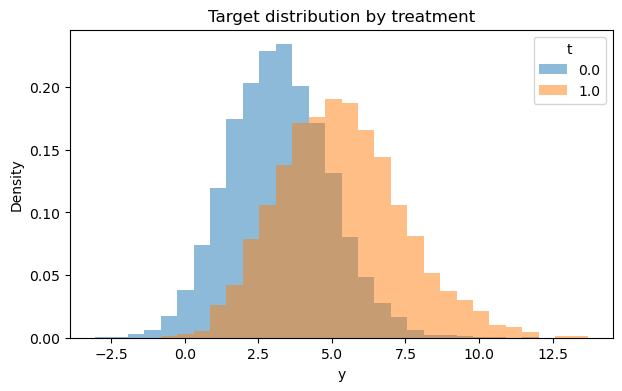

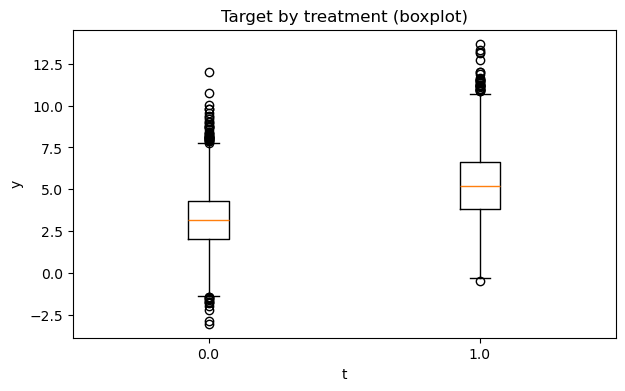

In [5]:
# 2) Outcome distribution by treatment (hist + boxplot)
fig1, fig2 = eda.outcome_plots()
plt.show()

### Propensity

Now let's examine how propensity score differ treatments

In [6]:
# Shows means of confounders for control/treated groups, absolute differences, and SMD values
confounders_balance_df = eda.confounders_means()
display(confounders_balance_df)

,mean_t_0,mean_t_1,abs_diff,smd
confounders,,,,
spend_last_month,90.246033,119.504887,29.258855,0.527431
premium_user,0.194823,0.354941,0.160118,0.364510
avg_sessions_week,4.903527,5.298734,0.395206,0.197970
urban_resident,0.576811,0.646211,0.069400,0.142734
tenure_months,23.337260,24.892263,1.555004,0.128836


In [7]:
# Propensity model fit
ps_model = eda.fit_propensity()

# ROC AUC - shows how predictable treatment is from confounders
roc_auc_score = ps_model.roc_auc
print("ROC AUC from PropensityModel:", round(roc_auc_score, 4))

ROC AUC from PropensityModel: 0.6924


In [8]:
# Positivity check - assess overlap between treatment groups
positivity_result = ps_model.positivity_check()
print("Positivity check from PropensityModel:", positivity_result)

Positivity check from PropensityModel: {'bounds': (0.05, 0.95), 'share_below': 0.0123, 'share_above': 0.0003, 'flag': False}


In [9]:
# SHAP values - feature importance for treatment assignment from confounders
shap_values_df = ps_model.shap
display(shap_values_df)

,feature,shap_mean,shap_mean_abs,odds_mult_abs,exact_pp_change_abs,exact_pp_change_signed
0,num__avg_sessions_week,-0.000709,0.231318,1.260259,0.053972,-0.000160
1,num__tenure_months,0.000493,0.176727,1.193305,0.040955,0.000111
2,num__premium_user,0.000182,0.350892,1.420334,0.082963,0.000041
3,num__urban_resident,0.000045,0.169130,1.184274,0.039157,0.000010
4,num__spend_last_month,-0.000011,0.571914,1.771655,0.137722,-0.000002


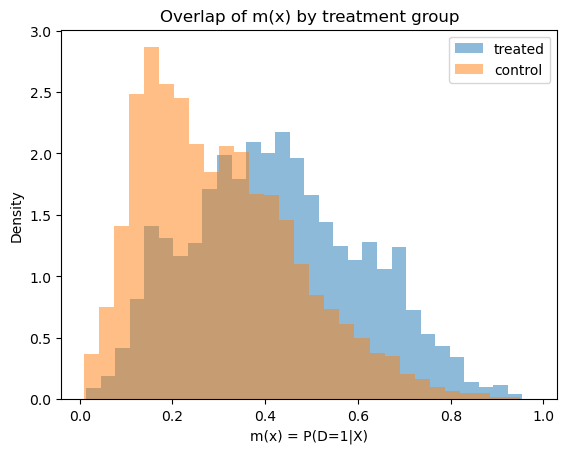

In [10]:
# Propensity score overlap graph
ps_model.ps_graph()
plt.show()

### Outcome regression

Let's analyze how confounders predict outcome

In [11]:
# Outcome model fit
outcome_model = eda.outcome_fit()

# RMSE and MAE of regression model
print(outcome_model.scores)

{'rmse': 1.203515978910883, 'mae': 0.9643596469055236}


In [12]:
# 2) SHAP values - feature importance for outcome prediction from confounders
shap_outcome_df = outcome_model.shap
display(shap_outcome_df)

,feature,shap_mean
0,premium_user,0.000558
1,tenure_months,-0.000404
2,avg_sessions_week,0.000242
3,spend_last_month,-0.000218
4,urban_resident,-0.000178


# Inference

Now time to estimate ATE with Double Machine Learning

In [13]:
from causalkit.inference.att import dml_att

# Estimate Average Treatment Effect (ATT)
att_result = dml_att(causal_data, normalize_ipw = True)

In [14]:
from causalkit.inference.ate import dml_ate
#
# # Estimate Average Treatment Effect (ATE)
ate_result = dml_ate(causal_data, normalize_ipw = False)

In [15]:
# ate_result

Real ATT is 1.385

## Refutation

In [16]:
from causalkit.refutation.overlap.overlap_validation import overlap_report_from_result

In [17]:
report = overlap_report_from_result(ate_result)

In [18]:
report

{'n': 10000,
 'n_treated': 3471,
 'p1': 0.3471,
 'eps': (0.01, 0.02),
 'edge_mass': {'share_below_001': 0.0,
  'share_above_001': 0.0,
  'share_below_002': 0.002,
  'share_above_002': 0.0,
  'min_m': 0.01,
  'max_m': 0.967738134749056},
 'edge_mass_by_arm': {'share_below_001_D1': 0.0,
  'share_above_001_D0': 0.0,
  'share_below_002_D1': 0.0002881014116969173,
  'share_above_002_D0': 0.0},
 'ks': 0.27980189354421175,
 'auc': 0.6917306952086957,
 'ate_ipw': {'sum_w1': 10896.839923099658,
  'sum_w0': 10252.743055285151,
  'mean_w1': 3.139394964880339,
  'mean_w0': 1.5703389577707387,
  'target_sum_w1': 3471.0,
  'target_sum_w0': 6529.0,
  'target_mean_w': nan},
 'ate_ess': {'ess_w1': 1980.1942052087606,
  'ess_w0': 5141.522417854527,
  'ess_ratio_w1': 0.5704967459546991,
  'ess_ratio_w0': 0.7874900318355839},
 'ate_tails': {'w1': {'q50': 2.408586261165248,
   'q95': 7.38726433314639,
   'q99': 32.46598823807997,
   'max': 72.82510972745777,
   'median': 2.408586261165248},
  'w0': {'q50':

In [19]:
print(report["flags"])

{'edge_mass_001': 'GREEN', 'edge_mass_002': 'GREEN', 'ks': 'YELLOW', 'auc': 'GREEN', 'ipw_sum_w1': 'NA', 'ipw_sum_w0': 'NA', 'ess_w1': 'GREEN', 'ess_w0': 'GREEN', 'tails_w1': 'YELLOW', 'tails_w0': 'YELLOW', 'att_identity': 'YELLOW', 'clip_m': 'GREEN'}


In [20]:
from causalkit.refutation.unconfoundedness.uncofoundedness_validation import validate_unconfoundedness_balance


In [21]:
balance = validate_unconfoundedness_balance(ate_result)

In [22]:
balance

{'smd': tenure_months        0.046788
 avg_sessions_week    0.018677
 spend_last_month     0.067443
 premium_user         0.025733
 urban_resident       0.002922
 dtype: float64,
 'smd_unweighted': tenure_months        0.128851
 avg_sessions_week    0.197992
 spend_last_month     0.527488
 premium_user         0.364552
 urban_resident       0.142749
 dtype: float64,
 'score': 'ATE',
 'normalized': False,
 'threshold': 0.1,
 'pass': True,
 'smd_max': 0.06744306721999557,
 'worst_features': spend_last_month     0.067443
 tenure_months        0.046788
 premium_user         0.025733
 avg_sessions_week    0.018677
 urban_resident       0.002922
 dtype: float64}

In [23]:
# Python
from causalkit.refutation.unconfoundedness.uncofoundedness_validation import (
    sensitivity_analysis, get_sensitivity_summary,
)

summary_str = sensitivity_analysis(ate_result, cf_y=0.01, cf_d=0.1, rho=1.0, level=0.95)
print(get_sensitivity_summary(ate_result))  # or print(summary_str)

================== Sensitivity Analysis ==================

------------------ Scenario          ------------------
Significance Level: level=0.95
Sensitivity parameters: cf_y=0.01; cf_d=0.1, rho=1.0

------------------ Bounds with CI    ------------------
          CI lower  theta lower           theta  theta upper      CI upper
     t    1.176719    -0.008472        1.237730     2.483933      1.298742

------------------ Robustness (SNR proxy) -------------
          H_0   SNR proxy (%)  adj (%)
     t    0.0        2.453301 0.000000


In [24]:

from causalkit.refutation.unconfoundedness.uncofoundedness_validation import (
sensitivity_benchmark
)

print(sensitivity_benchmark(ate_result, benchmarking_set=["premium_user"]))

       cf_y          cf_d  rho  theta_long  theta_short     delta
t  0.000013  8.152891e-07  1.0     1.23773     1.537911 -0.300181
